In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn_pandas import DataFrameMapper
import matplotlib.pyplot as plt

## Read Data

In [18]:
# Define a function to read data
def read_data(filepath, 
              col_names, 
              dtype_dict, 
              drop_cols=['fnlwgt', 'education_num']):
    data = pd.read_csv(filepath,header=None,names=col_names).astype(dtype_dict)
    data = data[list(set(col_names) - set(drop_cols))]
    return data

In [40]:
# Define column names and dtypes
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
             'marital_status', 'occupation', 'relationship', 'race', 'sex',
             'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'class']
dtype_dict = dict(zip(col_names,
                      ['int', 'category', 'float', 'category', 'float', 
                       'category', 'category', 'category', 'category', 'category',
                       'float', 'float', 'float', 'category', 'category']))

# Read data
train = read_data('./Data/adult/adult.data.csv',col_names,dtype_dict)
test = read_data('./Data/adult/adult.test.csv',col_names,dtype_dict)

## Explore Data

### Checking for missing values

First, check for missing values.

In [53]:
train.isnull().any()

sex               False
class             False
race              False
age               False
workclass         False
occupation        False
capital_gain      False
hours_per_week    False
capital_loss      False
education         False
relationship      False
native_country    False
marital_status    False
dtype: bool

There are no missing values.

### Examining numeric variables

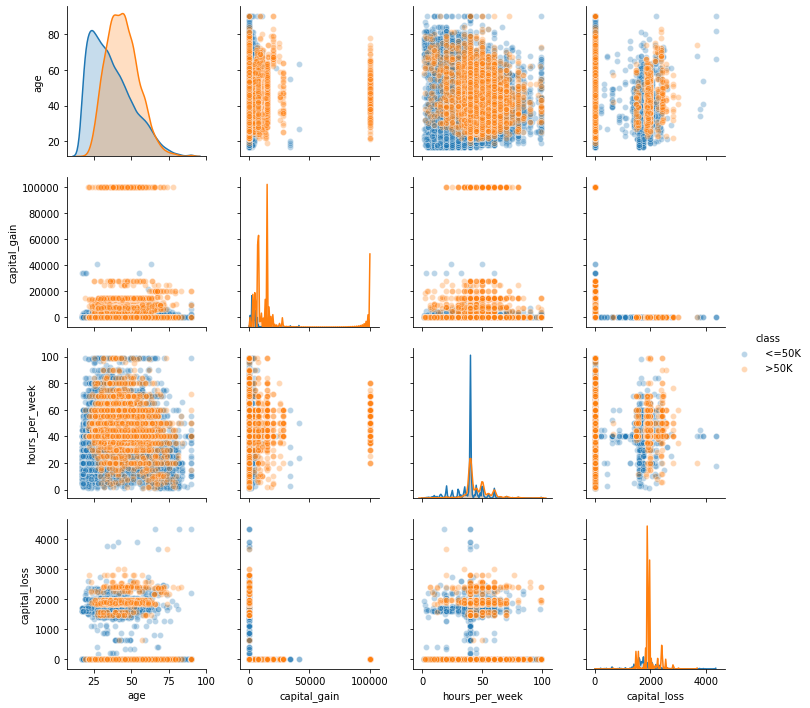

In [54]:
sns.pairplot(train,hue='class',plot_kws={'alpha': 0.3})

It would appear that for `capital_gain` values larger than 0, centering around 50K, there is a U-shaped relationship between the variable and the probability of belonging to the `>50K` class. Also, for `capital_loss` above 0, centering around 20K, there is a U-shaped relationship between the variable and the probability of belonging to the `<=50K` class. This suggest that is might be useful to include centered polynomial terms for both these variables.

There is a spherical blob formed by `hours_per_week` and `age`. We could try to craft a feature that helps us capture the outer parts of that blob which tend towards the `<=50K` class.

We won't examine the categorical variables on their own since they will mostly represent proportions on their own. Logistic regression will naturally handle by assigning the appropriate coefficient when estimating the log-odds equation. 

Looking at how the categories interact with the numeric variables will be more helpful.

In [89]:
def cat_num_bar(data, cat_var):
    fig, ax = plt.subplots(2,2,figsize=(16,8))
    sns.barplot(x=cat_var,y='age',hue='class',data=data,ax=ax[0][0])
    sns.barplot(x=cat_var,y='hours_per_week',hue='class',data=data,ax=ax[0][1])
    sns.barplot(x=cat_var,y='capital_gain',hue='class',data=data,ax=ax[1][0])
    sns.barplot(x=cat_var,y='capital_loss',hue='class',data=data,ax=ax[1][1])
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)

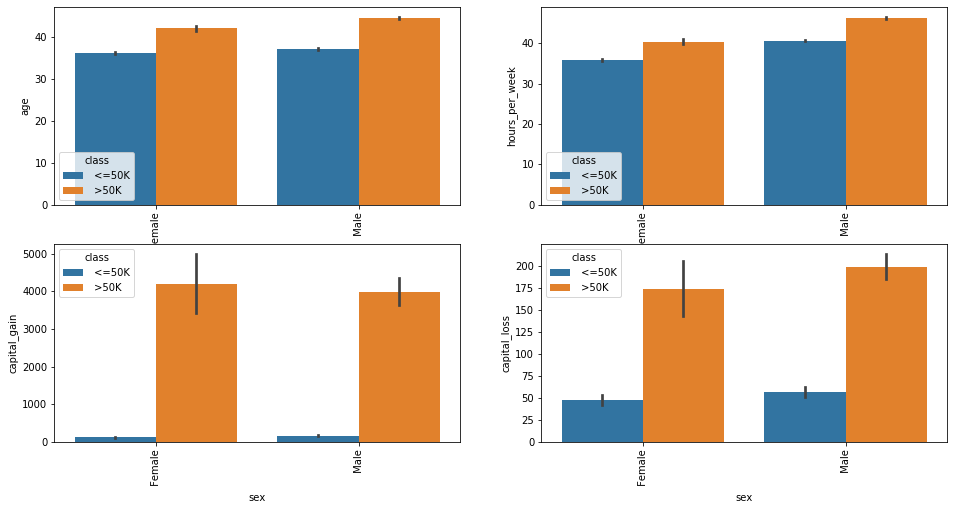

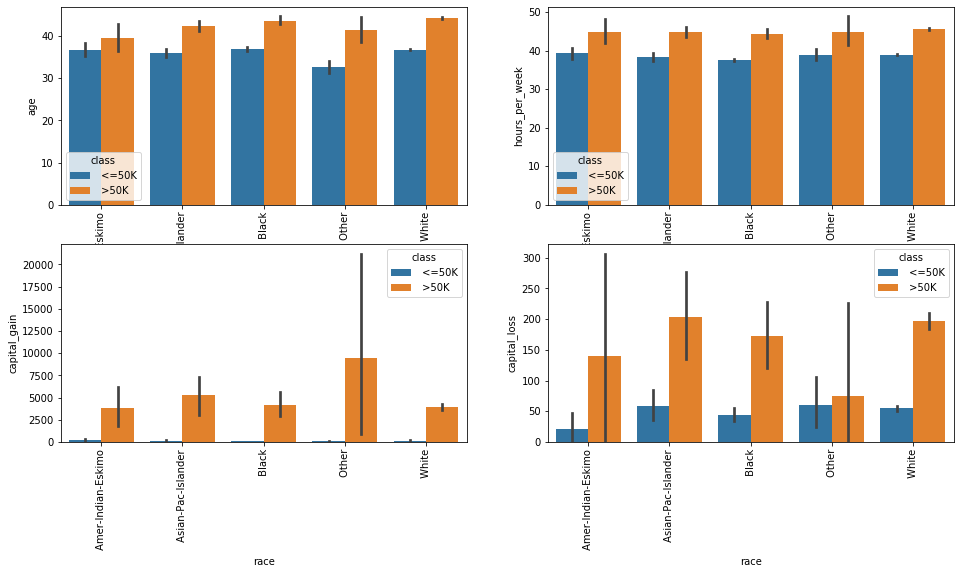

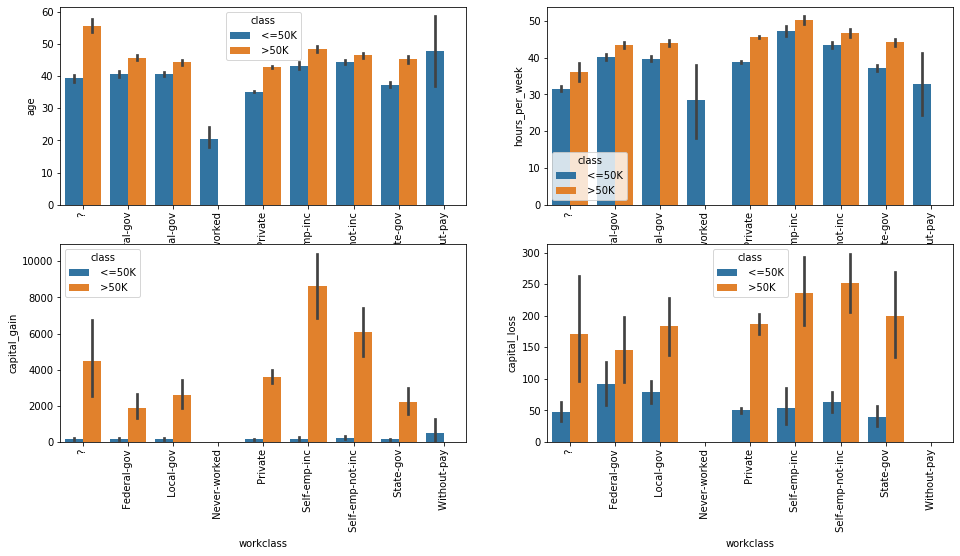

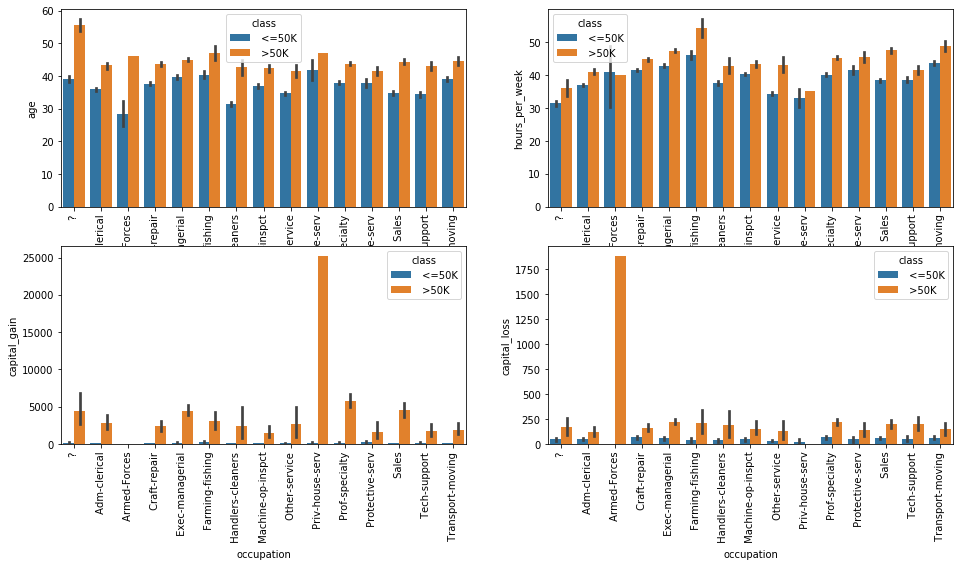

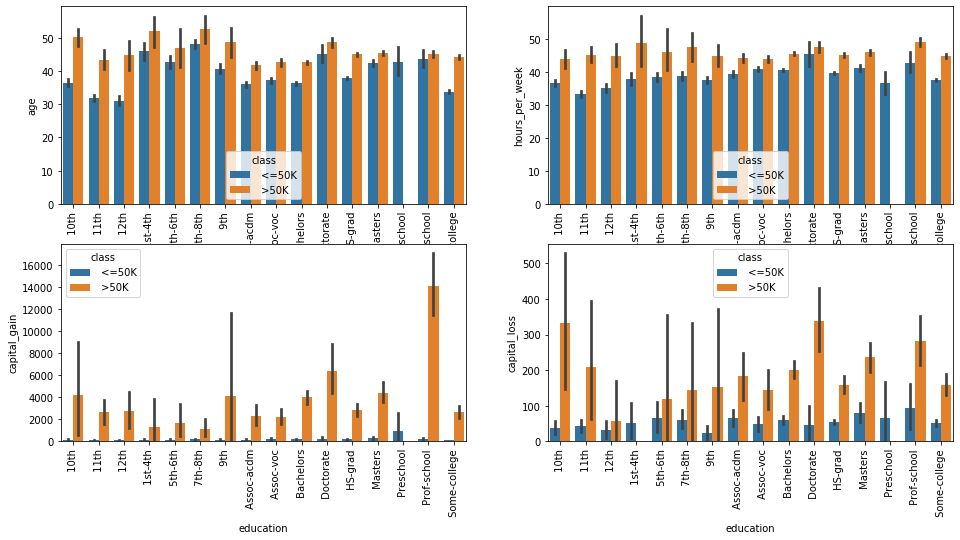

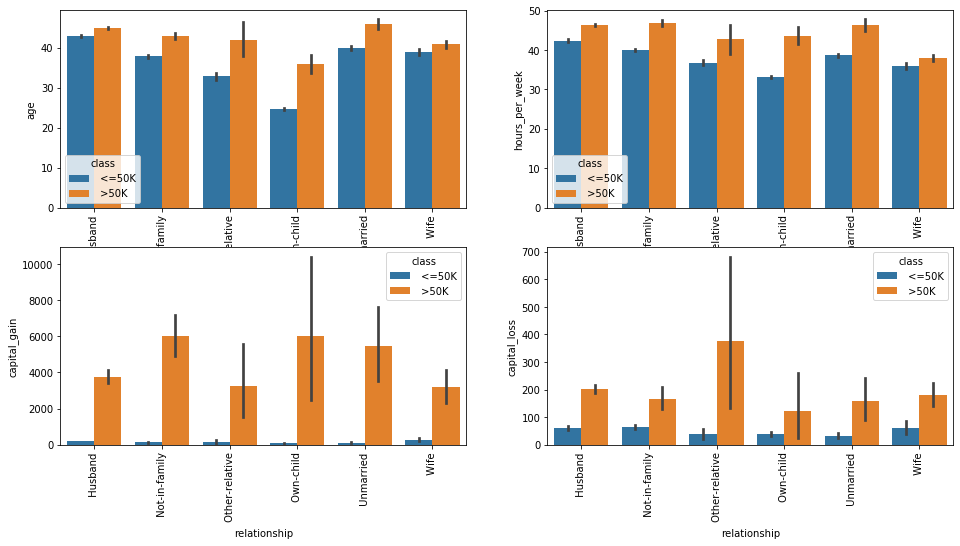

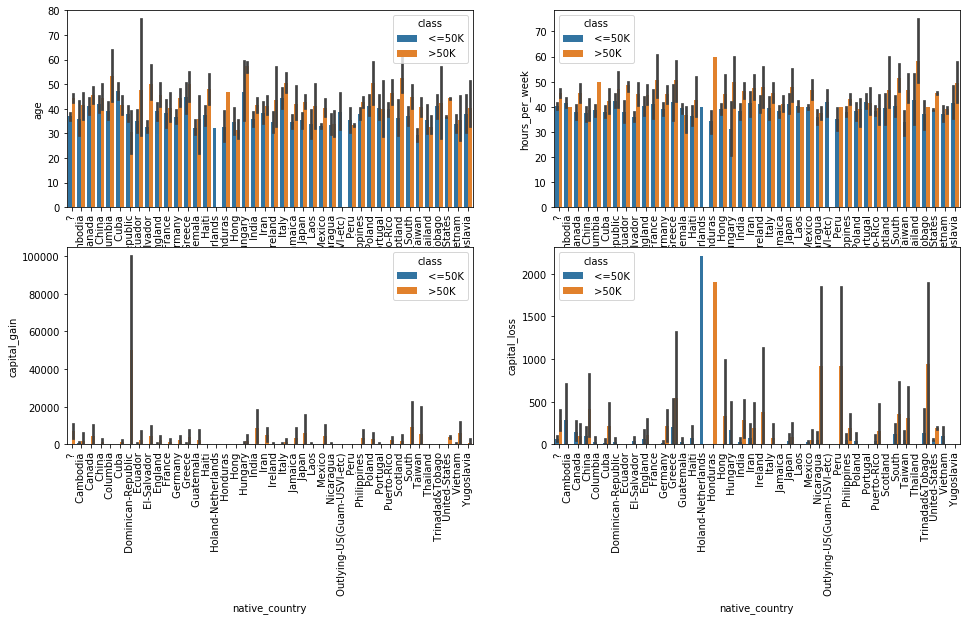

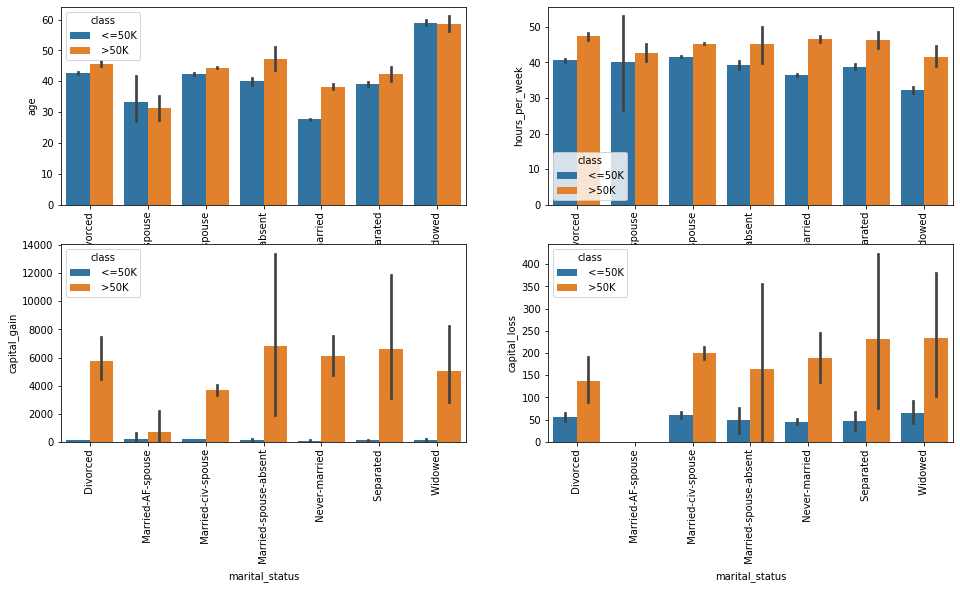

In [91]:
for cat_var in cat_cols:
    cat_num_bar(train, cat_var)

A cursory glance does not seem to suggest any potentially useful features to include. The distribution between both classes appear to be similar across all categories, after accounting for the numeric variable. That said, the `native_country` plots are tiny. Let's examine those more closely just to be sure.

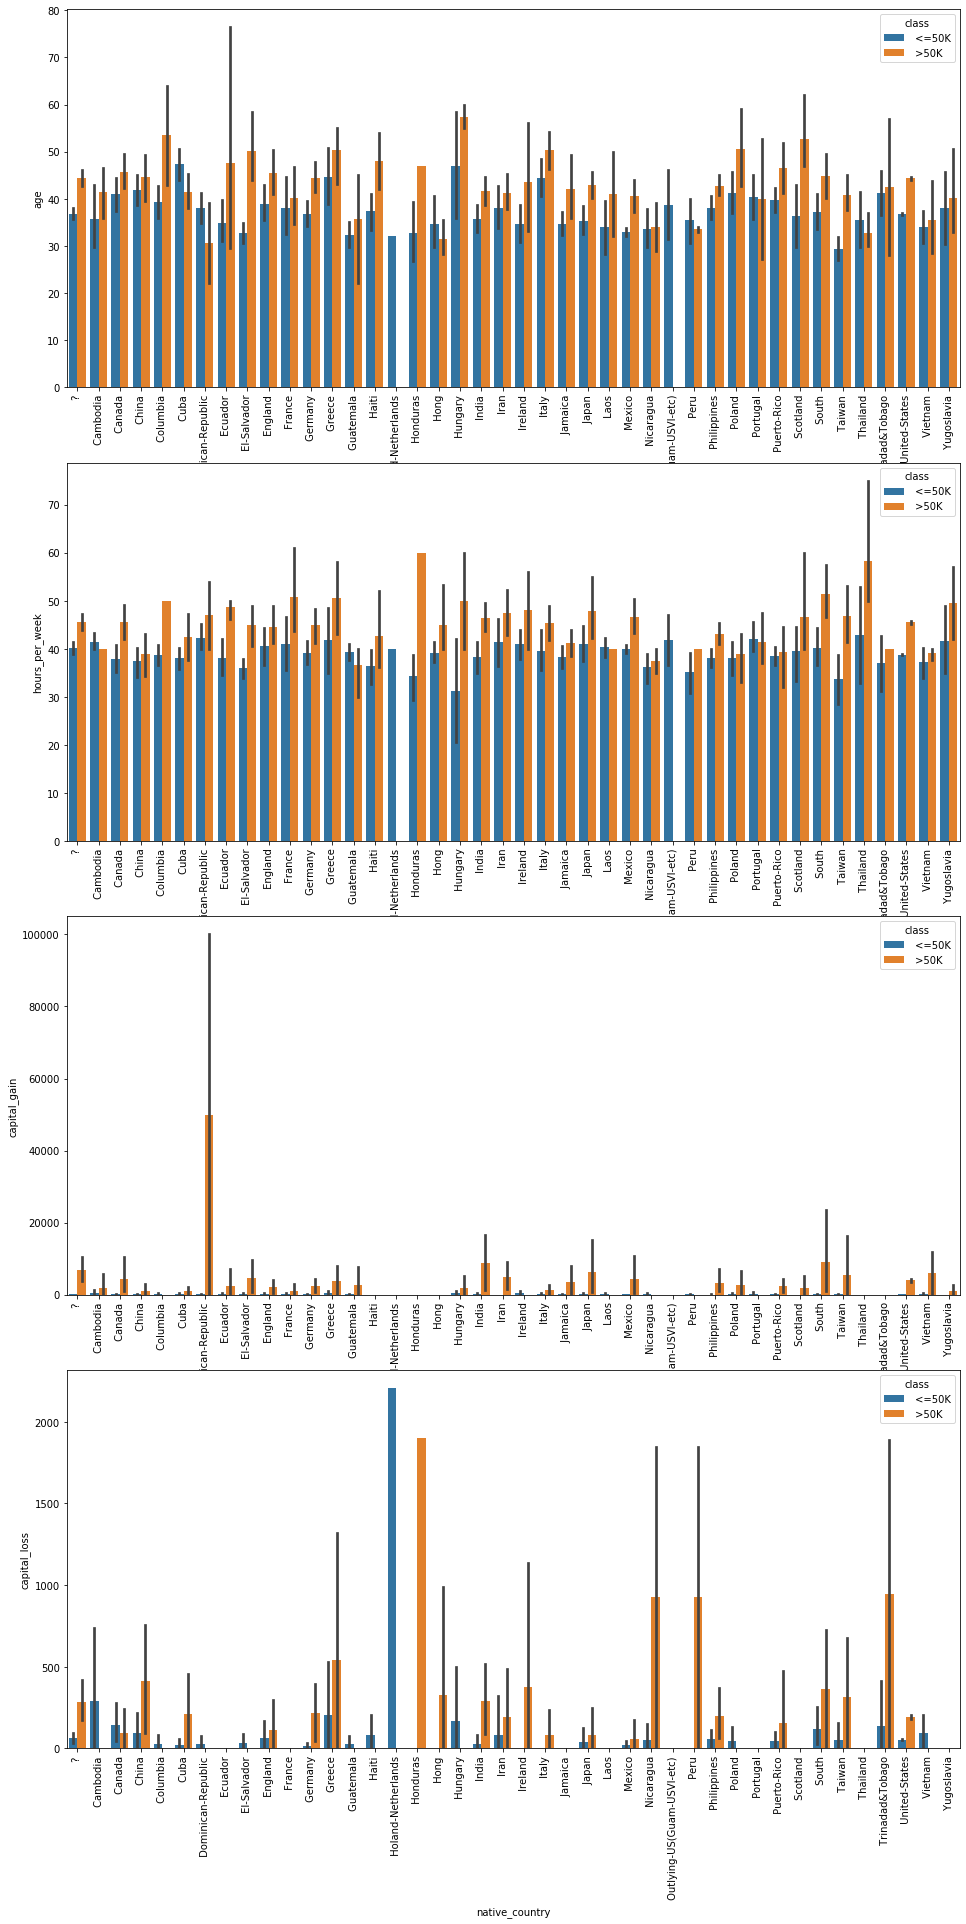

In [143]:
fig, ax = plt.subplots(4,1,figsize=(16,32))
sns.barplot(x='native_country',y='age',hue='class',data=train,ax=ax[0])
sns.barplot(x='native_country',y='hours_per_week',hue='class',data=train,ax=ax[1])
sns.barplot(x='native_country',y='capital_gain',hue='class',data=train,ax=ax[2])
sns.barplot(x='native_country',y='capital_loss',hue='class',data=train,ax=ax[3])
for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)

Looking at `age` and `native_country`, certain countries have a different distribution pattern from the rest. Namely, `Dominican-Republic` and `Peru`.

For `hours_per_week` and `native_country`, `Cambodia`, `Guatemala` and `Portugal` have different patterns from the rest.

For `capital_loss` and native_country`, `Canada` has a different distribution from the rest.

For these, we will add an interaction term.

## Build Model V1: No Feature Engineering

We will first build our model without adding in any additional handcrafted features.

In [98]:
# Get y vector
le = LabelEncoder()
train_y = le.fit_transform(train['class'])
test_y = le.transform(test['class'])

# Get X matrix
num_cols = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']
cat_cols = list(set(train.columns) - set(num_cols + ['class']))
mapper = DataFrameMapper([([num_col], [StandardScaler()]) for num_col in num_cols] + 
                         [([cat_col], [OneHotEncoder(sparse=False)]) for cat_col in cat_cols]) 
train_X = mapper.fit_transform(train[num_cols + cat_cols])
test_X = mapper.transform(test[num_cols + cat_cols])

In [99]:
# Initialize model
clf = LogisticRegression(fit_intercept=False,max_iter=10000,penalty='none',solver='sag',random_state=1298)

# Train model
clf.fit(train_X,train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=1298, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
def evaluate(X, labels, model):
    preds = model.predict(X)
    sns.heatmap(pd.DataFrame(confusion_matrix(labels,preds), 
                         index=['<=50K', '>50K'], 
                         columns=['<=50K', '>50K']),
                annot=True,
                cmap="YlGnBu",
                fmt='g')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    print('Accuracy: %s\nF1: %s\nPrecision: %s\nRecall: %s' \
          %(accuracy_score(labels,preds),
            f1_score(labels,preds), 
            precision_score(labels,preds), 
            recall_score(labels,preds)))

Accuracy: 0.8524308221491969
F1: 0.6633975481611208
Precision: 0.7359341000932546
Recall: 0.6038770564978957


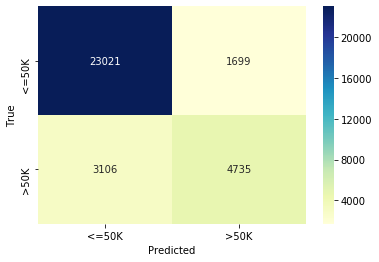

In [106]:
evaluate(train_X,train_y,clf)

## Build Model V2: Feature Engineering

Let's try to incorporate some of the features that we thought might help.

In [125]:
def augment_features(data):
    # Add an indicator for whether the capital gain or capital loss is more than 0
    data['cap_gain_above_zero'] = data['capital_gain'] > 0
    data['cap_loss_above_zero'] = data['capital_loss'] > 0
    # Add centered polynomial for capital gain and capital loss
    data['cap_gain_sq'] = np.square(data['capital_gain'] - 50000)
    data['cap_loss_sq'] = np.square(data['capital_loss'] - 20000)
    # Try to capture the spherical blob formed by age and hours_per_week
    data['age_hours_int'] = np.square(data['age'] - 50) * np.square(data['hours_per_week'] - 50)
    # Add in numeric and categorical interactions
    data['dominican_age'] = data['native_country'].astype('str').str.contains('Dominican-Republic') * data['age']
    data['peru_age'] = data['native_country'].astype('str').str.contains('Peru') * data['age']
    data['cambodia_hours'] = data['native_country'].astype('str').str.contains('Cambodia') * data['hours_per_week']
    data['guatemala_hours'] = data['native_country'].astype('str').str.contains('Guatemala') * data['hours_per_week']
    data['portugal_hours'] = data['native_country'].astype('str').str.contains('Portugal') * data['hours_per_week']
    data['canada_hours'] = data['native_country'].astype('str').str.contains('Canada') * data['capital_loss']
    return data

In [138]:
train_aug = augment_features(train)
test_aug = augment_features(test)
num_cols_aug = ['age', 'capital_gain', 'capital_loss', 'hours_per_week',
                'cap_gain_sq', 'cap_loss_sq', 'age_hours_int', 
                'dominican_age', 'peru_age', 'cambodia_hours', 
                'guatemala_hours', 'portugal_hours', 'canada_hours']
none_cols = ['cap_gain_above_zero', 'cap_loss_above_zero']
cat_cols_aug = list(set(train_aug.columns) - set(num_cols_aug + ['class'] + none_cols))
mapper_aug = DataFrameMapper([([num_col], [StandardScaler()]) for num_col in num_cols_aug] + 
                             [([cat_col], [OneHotEncoder(sparse=False)]) for cat_col in cat_cols_aug] + 
                             [(none_col, None) for none_col in none_cols]) 
train_aug_X = mapper_aug.fit_transform(train_aug)
test_aug_X = mapper_aug.transform(test_aug)

In [136]:
# Initialize model
clf2 = LogisticRegression(fit_intercept=False,max_iter=10000,penalty='none',solver='sag',random_state=1298)

# Train model
clf2.fit(train_aug_X,train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=1298, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy: 0.8581431774208409
F1: 0.6767895878524945
Precision: 0.7497674418604651
Recall: 0.6167580665731411


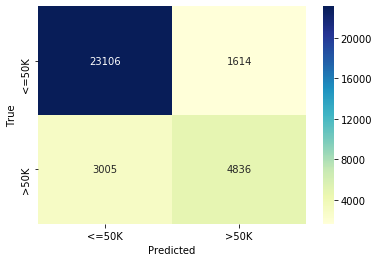

In [137]:
evaluate(train_aug_X,train_y,clf2)

The evaluation metrics improved only marginally, so it is a little hard to tell if the model is just overfitting. In any case, adding more features never lowers performance on the training set. This is why one should either use cross-validation or a validation set to estimate out-of-sample performance.

## Test Set Performance

Accuracy: 0.8518518518518519
F1: 0.6551329711181012
Precision: 0.7277636594663278
Recall: 0.5956838273530941


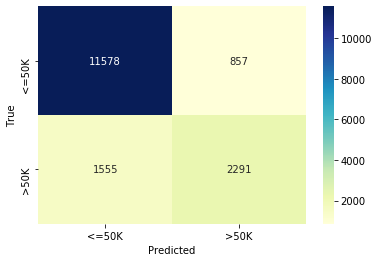

In [139]:
evaluate(test_X,test_y,clf)

Accuracy: 0.8563970272096308
F1: 0.6648509174311927
Precision: 0.7408945686900958
Recall: 0.6029641185647426


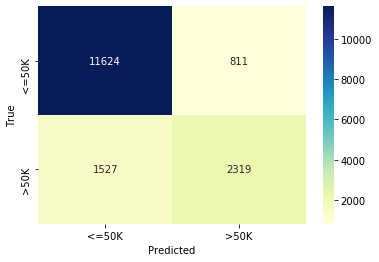

In [140]:
evaluate(test_aug_X,test_y,clf2)

Well, it appears the improve in performance gained from the additional features translated well into the test set performance.

We also note that the performance on the test set and training set is quite similar, suggesting that the model did pick up some discriminative patterns to classify the data.

## Build Model V3: Adjusting Class Weights

There is actually class imbalance in the dataset. How can we correct for this?

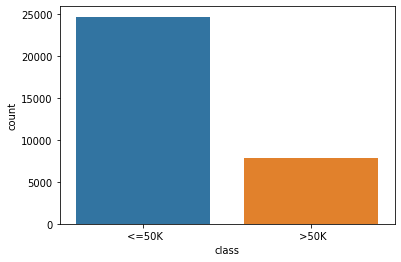

In [144]:
sns.countplot('class',data=train)

We can adjust the cost of misclassifying each class. Let's try making the cost of misclassifying the `>50K` class proportionally more in accordance to its prevalence in the dataset.

In [146]:
# Initialize model
clf_balance = LogisticRegression(fit_intercept=False,max_iter=10000,class_weight='balanced',
                                 penalty='none',solver='sag',random_state=1298)

# Train model
clf_balance.fit(train_aug_X,train_y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='none', random_state=1298, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

Accuracy: 0.8161604373330057
F1: 0.6908377233756844
Precision: 0.5805051644822498
Recall: 0.8529524295370489


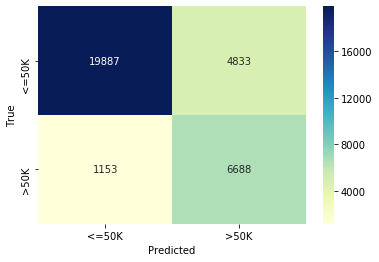

In [147]:
evaluate(train_aug_X,train_y,clf_balance)

Naturally, increasing the cost of misclassifying the minority `>50K` class will increase the recall and reduce precision.

Another way we could adjust the model's performance is to change the default 0.5 threshold.

In [156]:
def threshold_prediction(probabilities, threshold, label, score_function):
    preds = (probabilities < threshold) * 1
    return score_function(label,preds)

In [157]:
probs = clf_balance.predict_proba(train_aug_X)[:,0]
scores = [threshold_prediction(probs,x,train_y,f1_score) for x in np.arange(0,1,0.01)]

C:\Users\A0778044\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


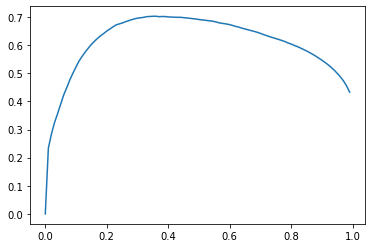

In [160]:
sns.lineplot(x=np.arange(0,1,0.01),y=scores)

In [165]:
max_f1 = np.max(scores)
opt_thres = np.arange(0,1,0.01)[np.where(scores == max_f1)]

To maximize the F1-score at 0.70, the optimal threshold is 0.36.

Accuracy: 0.848100488314241
F1: 0.7025141344881511
Precision: 0.6647694934547524
Recall: 0.7448029588062747


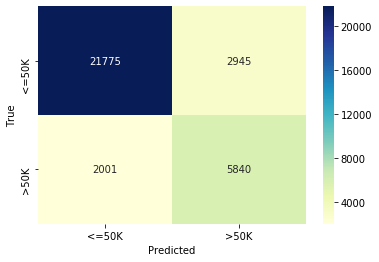

In [167]:
preds = (probs < opt_thres) * 1
sns.heatmap(pd.DataFrame(confusion_matrix(train_y,preds), 
                     index=['<=50K', '>50K'], 
                     columns=['<=50K', '>50K']),
            annot=True,
            cmap="YlGnBu",
            fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")
print('Accuracy: %s\nF1: %s\nPrecision: %s\nRecall: %s' \
      %(accuracy_score(train_y,preds),
        f1_score(train_y,preds), 
        precision_score(train_y,preds), 
        recall_score(train_y,preds)))

Accuracy: 0.8440513481972852
F1: 0.6889623912777166
Precision: 0.6513782719481122
Recall: 0.7311492459698388


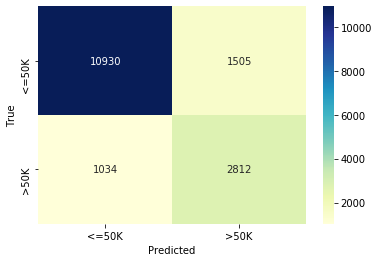

In [168]:
probs = clf_balance.predict_proba(test_aug_X)[:,0]
preds = (probs < opt_thres) * 1
sns.heatmap(pd.DataFrame(confusion_matrix(test_y,preds), 
                     index=['<=50K', '>50K'], 
                     columns=['<=50K', '>50K']),
            annot=True,
            cmap="YlGnBu",
            fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")
print('Accuracy: %s\nF1: %s\nPrecision: %s\nRecall: %s' \
      %(accuracy_score(test_y,preds),
        f1_score(test_y,preds), 
        precision_score(test_y,preds), 
        recall_score(test_y,preds)))